In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

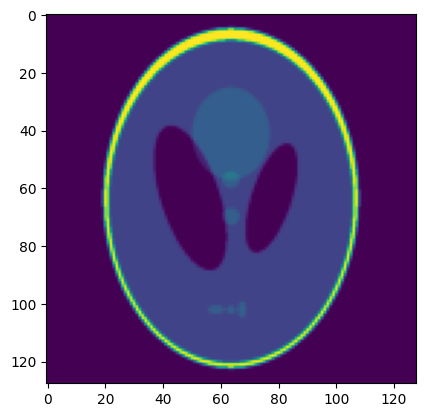

In [7]:
phantom = shepp_logan_phantom()
phantom= resize(phantom, (128, 128), mode='reflect', anti_aliasing=True)
plt.imshow(phantom)

In [18]:
# Python equivalent of interp2()
def interp2(image, x, y, method='linear', fill_value=0.0):
    
    nrows, ncols = image.shape
    # Compute center coordinates.
    cx = (ncols - 1) / 2.0
    cy = (nrows - 1) / 2.0
    
    x_coords = np.arange(ncols) - cx
    y_coords = np.linspace(cy, -cy, nrows)
    
    # Create the interpolator.
    interpolator = RegularGridInterpolator((y_coords, x_coords), image, 
                                           method=method, bounds_error=False, fill_value=fill_value)
    
    # Query points must be given as (y, x) pairs.
    points = np.column_stack((y, x))
    return interpolator(points)

In [19]:
def myXrayIntegration(image, t, theta, ds=1.0):
    
    nrows, ncols = image.shape
    # Compute image center.
    cx = (ncols - 1) / 2.0
    cy = (nrows - 1) / 2.0
    
    # Convert theta to radians.
    theta_rad = np.deg2rad(theta)

    # s_max is the distance from the center to a corner.
    s_max = np.hypot(cx, cy)
    s = np.arange(-s_max, s_max + ds, ds)
    
    # Parameterize the line:
    # x = t*cos(theta) - s*sin(theta)
    # y = t*sin(theta) + s*cos(theta)
    x = t * np.cos(theta_rad) - s * np.sin(theta_rad)
    y = t * np.sin(theta_rad) + s * np.cos(theta_rad)
    
    # Here, (x, y) are in our defined coordinate system.
    # Use interp2 to interpolate the image intensity at these points.
    line_values = interp2(image, x, y, method='linear', fill_value=0.0)
    
    # Numerically approximate the integral using the discrete sum.
    line_integral = np.sum(line_values) * ds
    return line_integral

In [ ]:
def myXrayCTRadonTransform(image, dt=5, dtheta=5, ds=1.0):
    # Define discrete values for t and θ.
    t_vals = np.arange(-90, 90 + dt, dt)   # from -90 to 90 in steps of 5 pixels.
    theta_vals = np.arange(0, 180, dtheta)      # from 0° to 175° in steps of 5°.
    
    # Preallocate the array for the Radon transform.
    R = np.zeros((len(t_vals), len(theta_vals)))
    
    # Loop over each angle and each t value.
    for j, theta in enumerate(theta_vals):
        for i, t in enumerate(t_vals):
            R[i, j] = myXrayIntegration(image, t, theta, ds)
    return R, t_vals, theta_vals


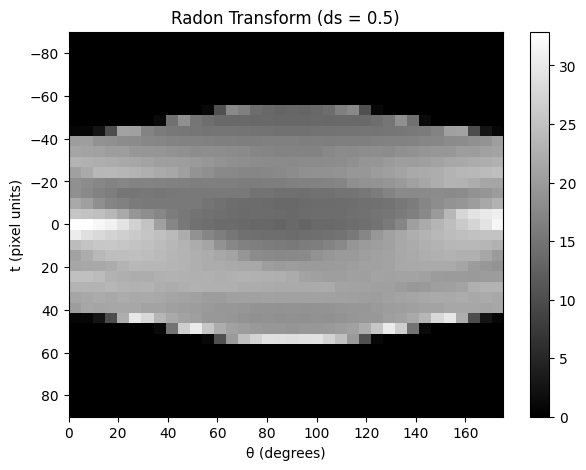

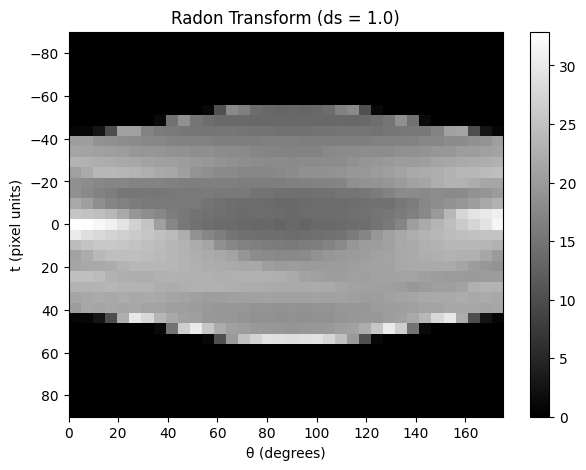

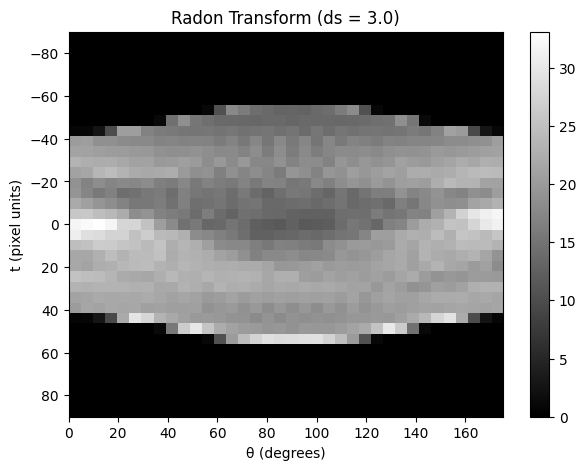

In [ ]:
ds_values = [0.5, 1.0, 3.0]
radon_transforms = {}

for ds in ds_values:
    R, t_vals, theta_vals = myXrayCTRadonTransform(phantom, dt=5, dtheta=5, ds=ds)
    radon_transforms[ds] = (R, t_vals, theta_vals)
    
    # Display the 2D Radon transform.
    plt.figure(figsize=(7,5))
    plt.imshow(R, extent=[theta_vals[0], theta_vals[-1], t_vals[-1], t_vals[0]], 
                aspect='auto', cmap='gray')
    plt.xlabel("θ (degrees)")
    plt.ylabel("t (pixel units)")
    plt.title(f"Radon Transform (ds = {ds})")
    plt.colorbar()
    plt.show()

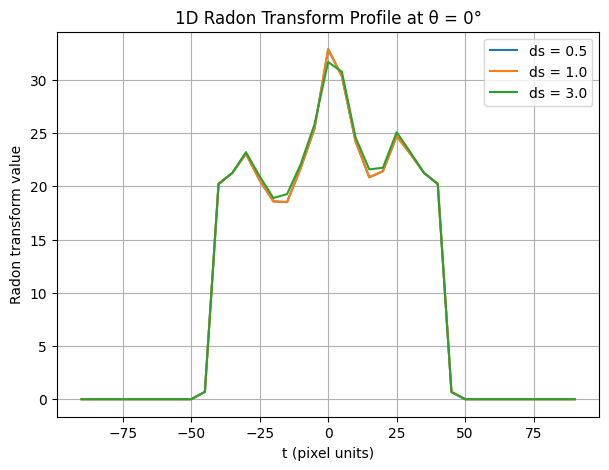

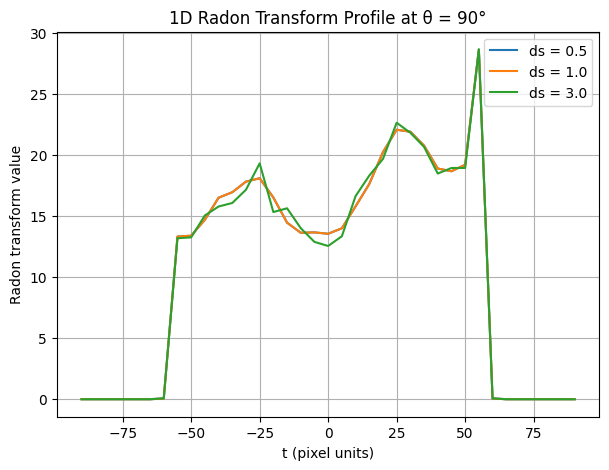

In [22]:
# For each ds value, plot the 1D Radon transform profiles at θ = 0° and θ = 90°.
for theta_target in [0, 90]:
    plt.figure(figsize=(7,5))
    for ds in ds_values:
        R, t_vals, theta_vals = radon_transforms[ds]
        # Find the column corresponding to the target angle.
        col_index = np.where(theta_vals == theta_target)[0]
        if col_index.size > 0:
            col_index = col_index[0]
            plt.plot(t_vals, R[:, col_index], label=f"ds = {ds}")
    plt.xlabel("t (pixel units)")
    plt.ylabel("Radon transform value")
    plt.title(f"1D Radon Transform Profile at θ = {theta_target}°")
    plt.legend()
    plt.grid(True)
    plt.show()